Stack Labs - Projeto Agrupamento e Segmentação de Clientes

Objetivo:

Produzir um modelo de agrupamento para segmentar clientes em categorias como cliente ouro, prata ou bronze baseado em atributos como receita média, quantidade de pedidos, retenção, recência.

Modelagem e Análise Exploratória dos Dados

Importando as bibliotecas:

In [2]:
import pandas as pd
import datetime 
import glob
import math
import seaborn as sns


In [3]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Carregando os dados - arquivos csv

In [4]:
customers = pd.read_csv('olist_customers_dataset.csv', sep=',')

In [5]:
orders = pd.read_csv('olist_orders_dataset.csv', sep=',')

In [6]:
order_payments = pd.read_csv('olist_order_payments_dataset.csv', sep=',')

Verificando cada um dos datasets:

Clientes

In [7]:
customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [8]:
customers.shape

(99441, 5)

In [9]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Pedidos

In [10]:
orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [11]:
orders.shape

(99441, 8)

In [12]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Pagamento dos Pedidos

In [13]:
order_payments.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [14]:
order_payments.shape

(103886, 5)

In [15]:
order_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

Mesclar os conjuntos de dados

In [16]:
olist_df = pd.merge(orders,order_payments, on="order_id")
olist_df = pd.merge(olist_df,customers, on="customer_id")

In [17]:
olist_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,credit_card,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


In [18]:
max_datet = max(olist_df['order_purchase_timestamp'])

In [19]:
max_datet

'2018-10-17 17:30:18'

In [20]:
min_datet = min(olist_df['order_purchase_timestamp'])

In [21]:
min_datet

'2016-09-04 21:15:19'

In [22]:
olist_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 175
order_delivered_carrier_date     1888
order_delivered_customer_date    3132
order_estimated_delivery_date       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [23]:
olist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       103886 non-null  object 
 1   customer_id                    103886 non-null  object 
 2   order_status                   103886 non-null  object 
 3   order_purchase_timestamp       103886 non-null  object 
 4   order_approved_at              103711 non-null  object 
 5   order_delivered_carrier_date   101998 non-null  object 
 6   order_delivered_customer_date  100754 non-null  object 
 7   order_estimated_delivery_date  103886 non-null  object 
 8   payment_sequential             103886 non-null  int64  
 9   payment_type                   103886 non-null  object 
 10  payment_installments           103886 non-null  int64  
 11  payment_value                  103886 non-null  float64
 12  customer_unique_id            

In [24]:
olist_df.shape

(103886, 16)

RFM - (Recency, Frequency, Monetary)

Monetary

In [25]:
monetary_df = olist_df.groupby('customer_unique_id')['payment_value'].sum()
monetary_df = monetary_df.reset_index()
monetary_df.columns = ['customer_unique_id', 'monetary']
monetary_df.head()

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


Frequency

In [26]:
frequency_df = olist_df.groupby('customer_unique_id')['order_id'].count()
frequency_df = frequency_df.reset_index()
frequency_df.columns = ['customer_unique_id', 'frequency']
frequency_df.head()

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [27]:
rfm_df = pd.merge(monetary_df, frequency_df, on = 'customer_unique_id', how='inner' )
rfm_df.head()

,customer_unique_id,monetary,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1
2,0000f46a3911fa3c0805444483337064,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,196.89,1


Recency

In [28]:
olist_df['order_purchase_timestamp'] = pd.to_datetime(olist_df['order_purchase_timestamp'], infer_datetime_format=True, errors='ignore')

max_date = max(olist_df['order_purchase_timestamp'])
olist_df['diff_days'] =  (max_date-olist_df['order_purchase_timestamp']).dt.days

In [29]:
recency_df = olist_df.groupby('customer_unique_id')['diff_days'].min()
recency_df = recency_df.reset_index()
recency_df.columns = ['customer_unique_id', 'recency']
recency_df.head()

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163
2,0000f46a3911fa3c0805444483337064,585
3,0000f6ccb0745a6a4b88665a16c9f078,369
4,0004aac84e0df4da2b147fca70cf8255,336


In [30]:
rfm_df = pd.merge (rfm_df, recency_df, on="customer_unique_id", how='inner')

In [31]:
rfm_df.head()

,customer_unique_id,monetary,frequency,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163
2,0000f46a3911fa3c0805444483337064,86.22,1,585
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,369
4,0004aac84e0df4da2b147fca70cf8255,196.89,1,336


In [32]:
rfm_df.describe()

,monetary,frequency,recency
count,96095.000000,96095.000000,96095.000000
mean,166.594226,1.081076,287.730756
std,231.428912,0.462548,153.407846
min,0.000000,1.000000,0.000000
25%,63.120000,1.000000,163.000000
50%,108.000000,1.000000,268.000000
75%,183.530000,1.000000,397.000000
max,13664.080000,33.000000,772.000000


Verificar Outliers

C:\Users\Jose Valente\anaconda3\envs\teste_kaggle\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='recency'>

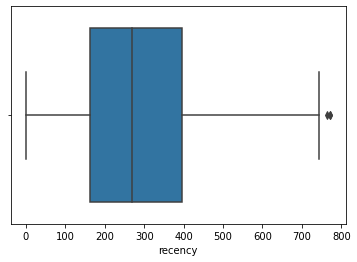

In [33]:
sns.boxplot(rfm_df['recency'])

C:\Users\Jose Valente\anaconda3\envs\teste_kaggle\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='frequency'>

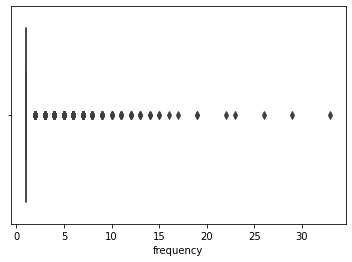

In [34]:
sns.boxplot(rfm_df['frequency'])

C:\Users\Jose Valente\anaconda3\envs\teste_kaggle\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='monetary'>

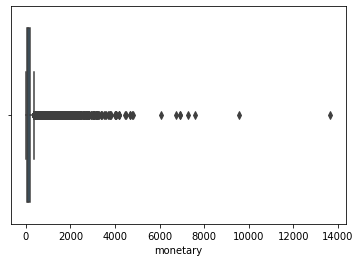

In [35]:
sns.boxplot(rfm_df['monetary'])

Remover outliers "monetary"

In [36]:
Q1 = rfm_df.monetary.quantile(0.05)
Q3 = rfm_df.monetary.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.monetary >= Q1 - 1.5*IQR) & (rfm_df.monetary <= Q3 + 1.5*IQR)]

Padronizar (transformar seus dados de forma que sua distribuição tenha um valor médio 0 e um desvio padrão 1)

In [37]:
rfm_df_scaled = rfm_df[['monetary', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df_scaled)
rfm_df_scaled.shape

(95178, 3)

In [38]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['monetary', 'frequency', 'recency']
rfm_df_scaled.head()

,monetary,frequency,recency
0,-0.062533,-0.173954,-0.832830
1,-0.843165,-0.173954,-0.813264
2,-0.441450,-0.173954,1.939117
3,-0.731355,-0.173954,0.530315
4,0.311689,-0.173954,0.315082


Curva (cotovelo)

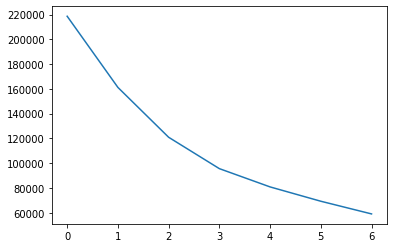

In [39]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    

plt.plot(ssd)

Silhouette

In [ ]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

Cluster - KMeans

In [40]:
kmeans = KMeans(n_clusters=3, max_iter=50,random_state=1)
kmeans.fit(rfm_df_scaled)
kmeans.labels_

array([1, 1, 2, ..., 2, 1, 2])

In [41]:
import pickle

In [42]:
pickle.dump(kmeans,open('modelo.sav','wb'))

In [43]:
rfm_df['cluster_id'] = kmeans.labels_

In [44]:
rfm_df.head(5)

,customer_unique_id,monetary,frequency,recency,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,160,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163,1
2,0000f46a3911fa3c0805444483337064,86.22,1,585,2
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,369,2
4,0004aac84e0df4da2b147fca70cf8255,196.89,1,336,2


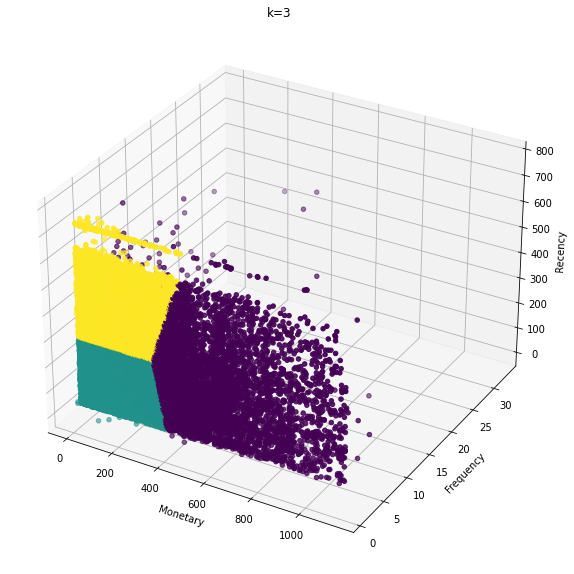

In [45]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(20,10))

ax.scatter(rfm_df.iloc[:,1], rfm_df.iloc[:,2], rfm_df.iloc[:,3],
                  c=kmeans.labels_, cmap='viridis')

ax.set_title('k=3')
    
ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
plt.savefig('Graficokmeans.png')

<AxesSubplot:xlabel='cluster_id', ylabel='monetary'>

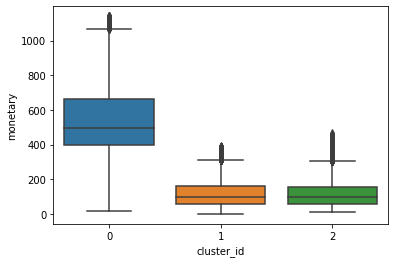

In [46]:
sns.boxplot(x='cluster_id', y='monetary', data=rfm_df)

Os clientes em cluster_id 0 estão gastando mais do que outros clientes

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

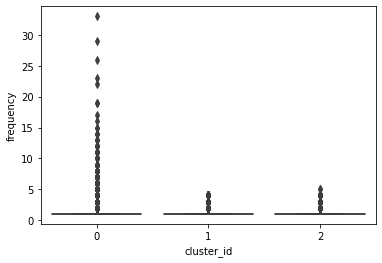

In [47]:
sns.boxplot(x='cluster_id', y='frequency', data=rfm_df)

<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

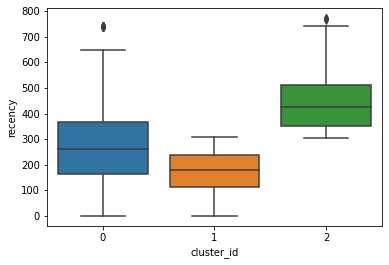

In [48]:
sns.boxplot(x='cluster_id', y='recency', data=rfm_df)

Os clientes em cluster_id 1 fizeram compras mais recentemente do que outros

Cluster 0 (Azul): Clientes que gastam muito e fizeram compras em tempo intermediario

Cluster 1 (Laranja): Clientes que gastam pouco e fizeram compras mais recente 

Cluster 2 (Verde): Clientes que gastam pouco e fizeram compras a mais tempo 

In [49]:
rfm_data = rfm_df

In [50]:
def get_segment(data):
        
    if (data['cluster_id'] == 0) :
        return 'Ouro'
    if (data['cluster_id'] == 1):
        return 'Prata'
    if (data['cluster_id'] == 2):
        return 'Bronze'
    return 'não se enquadra'

In [51]:
rfm_data['segment'] = rfm_data.apply(get_segment,axis=1)

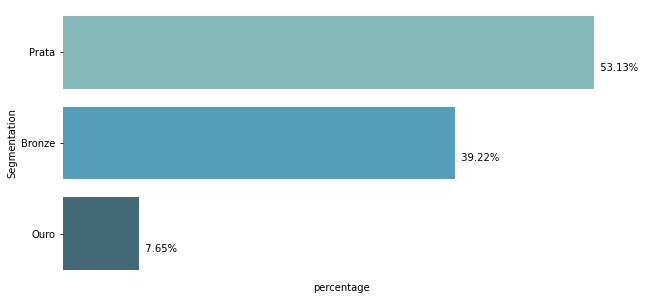

In [52]:
plt.figure(figsize=(10,5))
percentage = (rfm_data['segment'].value_counts(normalize=True)* 100).reset_index(name='percentage')
g = sns.barplot(x=percentage['percentage'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['percentage']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.show()

Bronze: Clientes que gastam pouco e faz tempo que compraram

Prata: Clientes que gastam pouco e fizeram compras mais recente 

Ouro: Clientes que gastam muito e fizeram compras em um tempo intermediario


In [53]:
rfm_df.to_csv("projetostacklabs_rfm.csv", index = None, header=True)